# Bar Graph Classification

Teng-Jui Lin

- Created: 2023-05-27
- Edited: 2024-05-28

In [1]:
from bar_constants import *
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
df = pd.read_excel(bar_classification_sorted_filepath)
df = df.set_index('Journal')
df

,Total number of articles,Number of articles without bar graphs,Number of articles with bar graphs,Number of articles with correct bar graphs,Number of articles with incorrect bar graphs,Number of articles with nonzero bar graph y-min,Number of articles with logarithmic bar graph y axis,Number of articles with other bar graph misrepresentations,Percentage of articles without bar graphs,Percentage of articles with bar graphs,Percentage of articles with correct bar graphs,Percentage of articles with incorrect bar graphs,Percentage of articles with nonzero bar graph y-min,Percentage of articles with logarithmic bar graph y axis,Percentage of articles with other bar graph misrepresentations
Journal,,,,,,,,,,,,,,,
Nature Biomedical Engineering *,109,18,91,50,41,23,21,2,16.513761,83.486239,54.945055,45.054945,25.274725,23.076923,2.197802
Cell,297,14,283,175,108,48,63,7,4.713805,95.286195,61.837456,38.162544,16.961131,22.261484,2.473498
Science Translational Medicine,248,24,224,139,85,49,34,14,9.677419,90.322581,62.053571,37.946429,21.875000,15.178571,6.250000
Science Immunology,116,5,111,73,38,21,22,4,4.310345,95.689655,65.765766,34.234234,18.918919,19.819820,3.603604
Nature Cancer *,75,0,75,53,22,7,17,2,0.000000,100.000000,70.666667,29.333333,9.333333,22.666667,2.666667
Nature Nanotechnology †*,55,10,45,32,13,7,5,2,18.181818,81.818182,71.111111,28.888889,15.555556,11.111111,4.444444
Nature †,554,67,487,356,131,79,58,8,12.093863,87.906137,73.100616,26.899384,16.221766,11.909651,1.642710
Nature Biotechnology *,157,17,140,103,37,12,24,5,10.828025,89.171975,73.571429,26.428571,8.571429,17.142857,3.571429
Nature Cell Biology *,120,3,117,90,27,16,12,1,2.500000,97.500000,76.923077,23.076923,13.675214,10.256410,0.854701


In [3]:
percent_bar_df = df.loc[:, [
    'Percentage of articles with bar graphs', 
    'Percentage of articles without bar graphs',
]]
percent_bar_correct_df = df.loc[:, [
    'Percentage of articles with incorrect bar graphs', 
    'Percentage of articles with correct bar graphs',
]]
percent_bar_incorrect_df = df.loc[:, [
    'Percentage of articles with nonzero bar graph y-min',
    'Percentage of articles with logarithmic bar graph y axis',
    'Percentage of articles with other bar graph misrepresentations',
]]
total_articles_series = df.loc[:, 'Total number of articles']

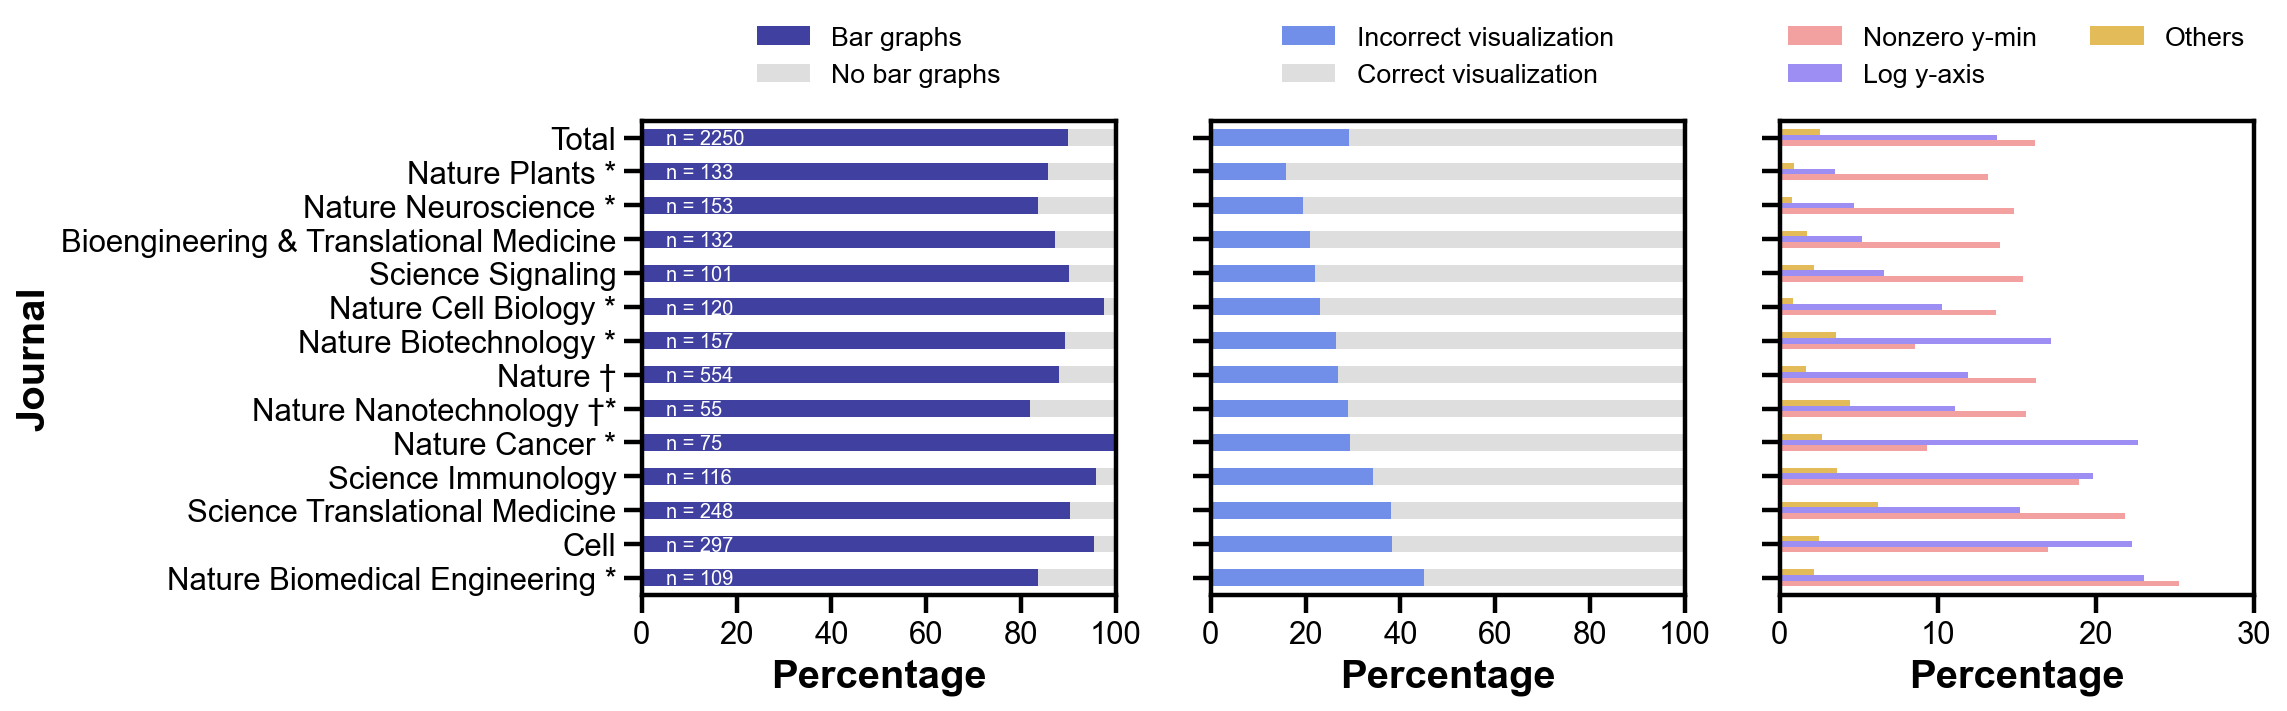

In [4]:
alpha = 0.75
fig, axs = plt.subplots(1, 3, figsize=(13, 4), sharey=True)
percent_bar_df.plot(
    kind='barh', 
    stacked=True, 
    ax=axs[0],
    legend=False,
    alpha=alpha,
    color=['navy', 'lightgray'], 
)
percent_bar_correct_df.plot(
    kind='barh', 
    stacked=True, 
    ax=axs[1],
    legend=False,
    alpha=alpha,
    color=['royalblue', 'lightgray'], 
)
percent_bar_incorrect_df.plot(
    kind='barh', 
    stacked=False, 
    ax=axs[2],
    legend=True,
    alpha=alpha,
    color=['lightcoral', 'mediumslateblue', 'goldenrod'], 
)
axs[2].set_xlim(0, 30)
for i in range(2):
    axs[i].set_xlim(0, 100)
for i in range(3):
    axs[i].set_box_aspect(1)
    axs[i].set_xlabel('Percentage')
axs[0].legend(
    ['Bar graphs', 'No bar graphs'], 
    bbox_to_anchor=(0.5, 1.02), 
    loc='lower center',
)
axs[1].legend(
    ['Incorrect visualization', 'Correct visualization'], 
    bbox_to_anchor=(0.5, 1.02), 
    loc='lower center',
)
axs[2].legend(
    ['Nonzero y-min', 'Log y-axis', 'Others'], 
    bbox_to_anchor=(0.5, 1.02), 
    loc='lower center',
    ncol=2,
)
for i in range(total_articles_series.shape[0]):
    try:
        axs[0].text(5, i - 0.2, f'n = {int(total_articles_series.iloc[i])}', fontsize=9, color='w')
    except ValueError:
        pass    
# plt.tight_layout()

## Error Quantification

In [5]:
journal_list = ['nat_plants',
 'nat_biotechnol',
 'sci_immunol',
 # 'nature',
 # 'cell',
 'nat_cancer',
 # 'sci_transl_med',
 'nat_neurosci',
 'nat_cell_biol',
 'bioeng_transl_med',
 'sci_signal',
 'nat_nanotechnol',
 'nat_biomed_eng',]
mistakes_list = ['zero', 'log']
file_df = pd.DataFrame()
for j, mistake in enumerate(mistakes_list):
    for i, journal in enumerate(journal_list):
        filepath = f'data/misused_bar_graph_figures/{journal}/{mistake}'
        file_list = pd.Series(os.listdir(filepath))
        file_list = file_list.str.replace('.png', '')
        file_list = file_list.str.replace('fig', '')
        new_file_df = file_list.str.split('_', expand=True)
        new_file_df.columns = ['DOI', 'Mistake', 'Fig ID']
        new_file_df['Journal'] = journal
        file_df = pd.concat([file_df, new_file_df], ignore_index=True)

In [6]:
df = pd.concat([
    file_df.groupby(['DOI', 'Mistake']).agg({'Journal': lambda x: np.unique(x)[0]}),
    file_df.groupby(['DOI', 'Mistake']).agg({'Fig ID': 'count'}),
], axis=1)
df

,,Journal,Fig ID
DOI,Mistake,,
.DS,Store,sci_signal,0
10.1002:btm2.10487,log,bioeng_transl_med,2
10.1002:btm2.10499,zero,bioeng_transl_med,6
10.1002:btm2.10504,zero,bioeng_transl_med,1
10.1002:btm2.10505,zero,bioeng_transl_med,2
...,...,...,...
10.1126:scisignal.ade6737,zero,sci_signal,3
10.1126:scisignal.adf9535,zero,sci_signal,4
10.1126:scisignal.adg0699,log,sci_signal,4


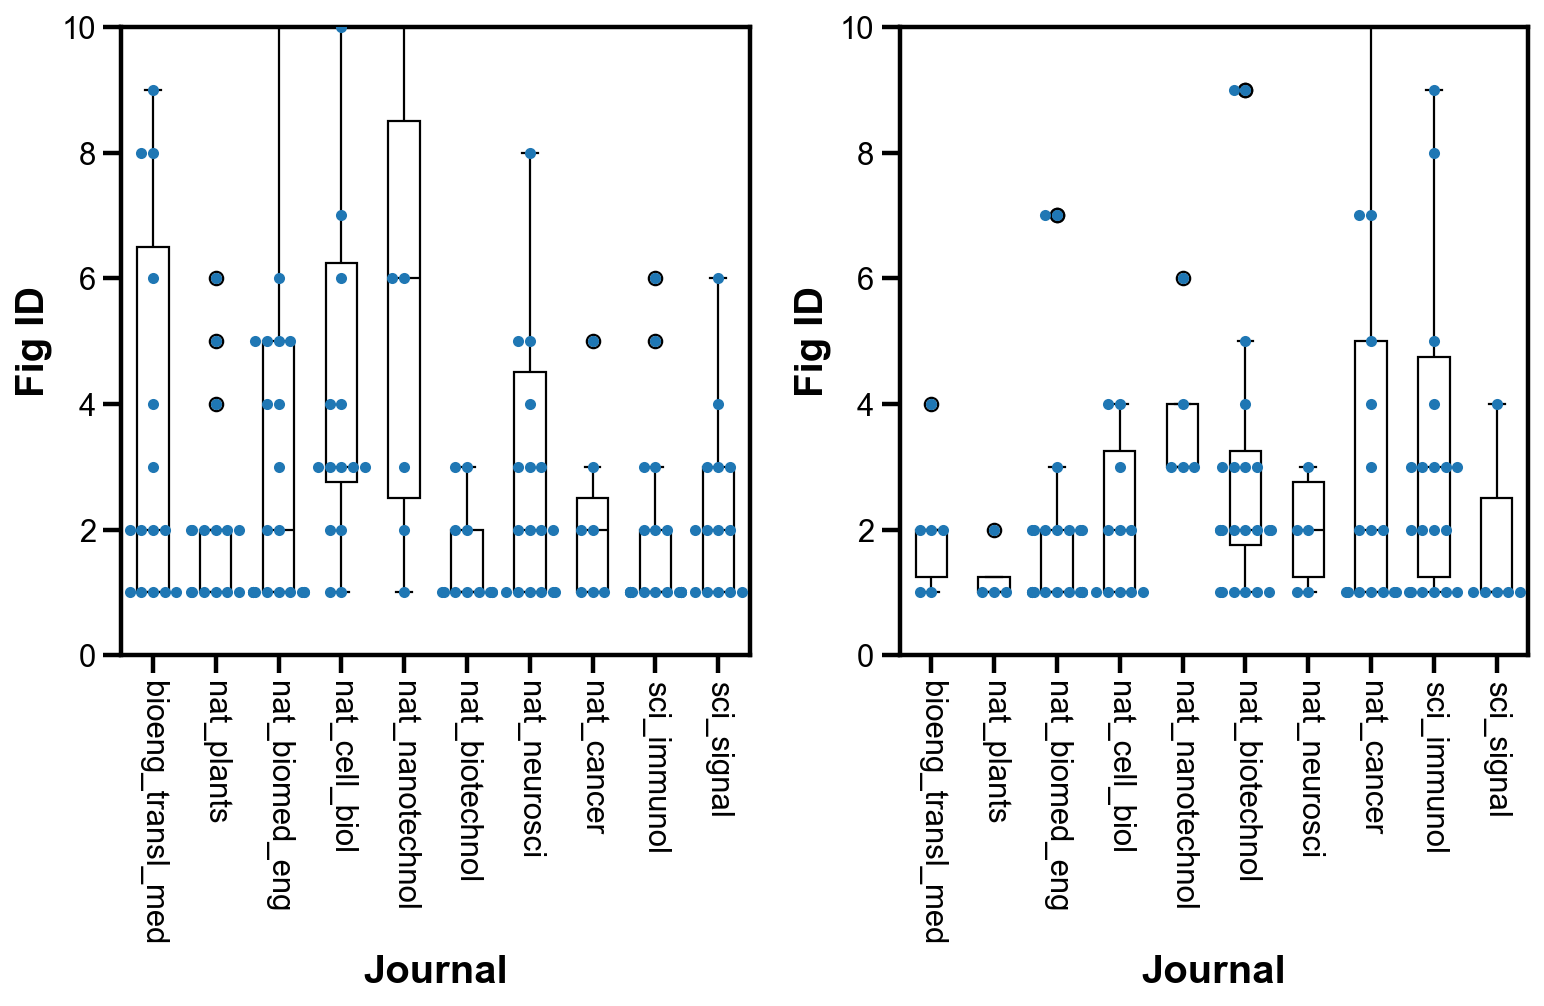

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(10, 7))
sns.boxplot(
    df[df.index.get_level_values(1) == 'zero'],
    x='Journal',
    y='Fig ID',
    ax=axs[0],
    log_scale=False,
    color='w',
    linecolor='k',
    width=0.5,
)
sns.swarmplot(
    df[df.index.get_level_values(1) == 'zero'],
    x='Journal',
    y='Fig ID',
    ax=axs[0],
)

sns.boxplot(
    df[df.index.get_level_values(1) == 'log'],
    x='Journal',
    y='Fig ID',
    ax=axs[1],
    log_scale=False,
    color='w',
    linecolor='k',
    width=0.5,
)
sns.swarmplot(
    df[df.index.get_level_values(1) == 'log'],
    x='Journal',
    y='Fig ID',
    ax=axs[1],
)
for i in range(2):
    axs[i].set_box_aspect(1)
    axs[i].set_ylim(0, 10)
    axs[i].set_xticklabels(axs[1].get_xticklabels(), rotation=-90, fontsize=14)
plt.tight_layout()

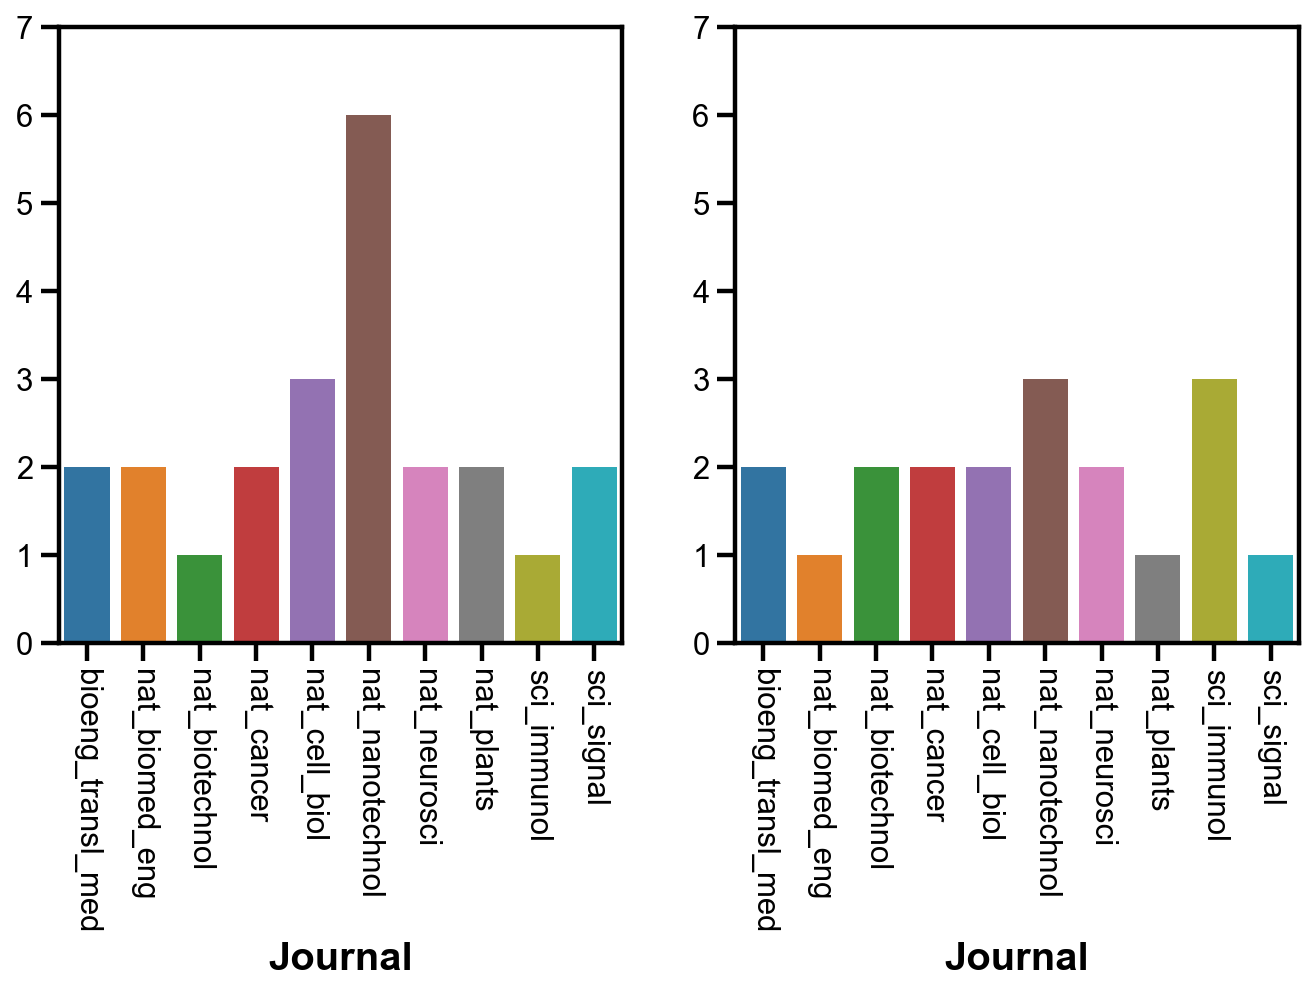

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
sns.barplot(
    df[df.index.get_level_values(1) == 'zero'].groupby('Journal').agg({'Fig ID': 'median'}).T,
    ax=axs[0],
)
axs[0].set_ylim(0, 7)
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=-90, fontsize=14)

sns.barplot(
    df[df.index.get_level_values(1) == 'log'].groupby('Journal').agg({'Fig ID': 'median'}).T,
    ax=axs[1],
)
axs[1].set_ylim(0, 7)
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=-90, fontsize=14);

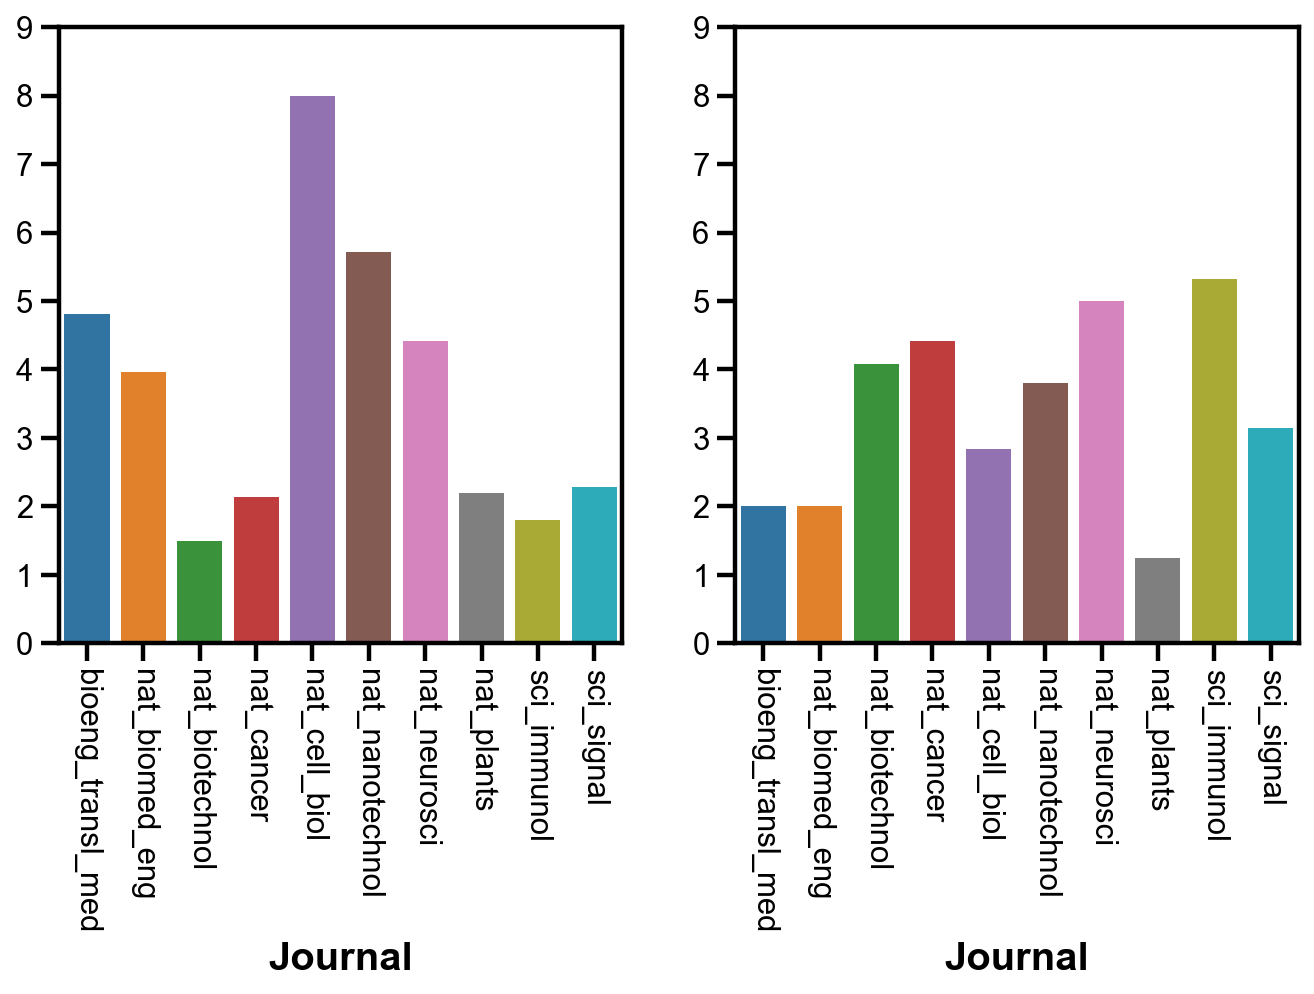

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
sns.barplot(
    df[df.index.get_level_values(1) == 'zero'].groupby('Journal').agg({'Fig ID': 'mean'}).T,
    ax=axs[0],
)
axs[0].set_ylim(0, 9)
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=-90, fontsize=14)

sns.barplot(
    df[df.index.get_level_values(1) == 'log'].groupby('Journal').agg({'Fig ID': 'mean'}).T,
    ax=axs[1],
)
axs[1].set_ylim(0, 9)
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=-90, fontsize=14);

In [10]:
author_filename = f'data/zotero_data/{journal}.csv'


In [11]:
author_df = pd.read_csv(author_filename)['Author'].str.split(';', expand=True)

<Axes: >

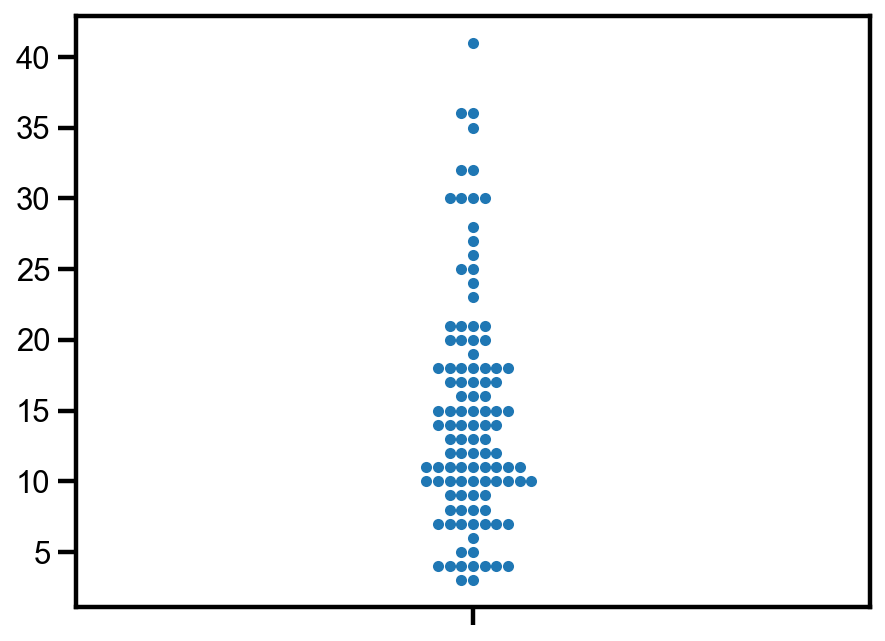

In [12]:
sns.swarmplot((~pd.isna(author_df)).sum(axis=1))

In [13]:
(~pd.isna(author_df)).sum(axis=1)

0      30
1       5
2      17
3      17
4      16
       ..
104    15
105     7
106    17
107    30
108    11
Length: 109, dtype: int64

In [14]:
# construct a huge df for zotero data. 
# match for DOIs
# filter for only mistake plots
# quantify incorrect graph # vs author